In [1]:
%cd ..

/Users/maxsemakov/Documents/test_kvant


Скачиваем датасеты

In [2]:
# если вы уже скачали датасеты, то пропустите эту ячейку
! git clone -b datasets https://github.com/maxsemakov/test_kvant.git

Cloning into 'test_kvant'...
remote: Enumerating objects: 932714, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 932714 (delta 37), reused 76 (delta 15), pack-reused 932612
Receiving objects: 100% (932714/932714), 2.05 GiB | 1.83 MiB/s, done.
Resolving deltas: 100% (487/487), done.
Updating files: 100% (948642/948642), done.


In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # you can also use jax, tensorflow or torch


import keras
import tensorflow as tf
import keras_cv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

import sys
import platform

In [5]:
print("ОС: ", platform.system())
print("Архитектура: ", platform.machine())
print("Версия Python: ", sys.version_info)

ОС:  Darwin
Архитектура:  arm64
Версия Python:  sys.version_info(major=3, minor=11, micro=6, releaselevel='final', serial=0)


In [6]:
print(tf.__version__)
try:
    print(keras.__version__)
except:
    print('Tf.Keras')
print(keras_cv.__version__)

2.16.1
3.2.1
0.8.2


In [7]:
# Определите и инициализируйте TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('TPU active')
except ValueError:
    tpu = None
    print('TPU non active')

# Создайте стратегию распределения
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    gpus = tf.config.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
            
    if len(gpus) >= 2:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

print("Number of replicas:", strategy.num_replicas_in_sync)
print(tf.config.list_physical_devices())

TPU non active
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of replicas: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
tf.test.gpu_device_name()

2024-04-18 13:44:42.060068: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-18 13:44:42.060088: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-18 13:44:42.060096: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-18 13:44:42.060113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 13:44:42.060127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

# Config

In [10]:
class Config:
    
    DEV = "TPU" if tpu else "GPU"
    if tpu:
        CACHE=True
        CACHE_DIR=""
    else:
        CACHE=False
        CACHE_DIR=""
        
    VERSION = 1
    DF_VERSION = 1
    MIX = 0 # USE MIXED PRECISION
    SEED = 42
    IMAGE_SIZE = (128, 256) 
    BATCH_SIZE = 256* strategy.num_replicas_in_sync
    EPOCHS = 25
    EARLY_STOPPING = 6 # Количество эпох через которое надо остановить обучение если нет улучшения результата
    LR_MODE = 'cos' #'exp' , 'step' - режим измененмя скорости обучения
    
    CLASS_NAMES = ['BrassMono-BoldItalic', 
                   'GhastlyPanicCyr', 
                   'ambidexter_regular',
                   'GaneshaType-Regular', 
                   'AlumniSansCollegiateOne-Italic',
                   'AlumniSansCollegiateOne-Regular', 
                   'BrassMono-Italic',
                   'better-vcr-5.2', 
                   'ArefRuqaaInk-Bold', 
                   'Aguante-Regular',
                   'BrassMono-Bold', 
                   'ArefRuqaaInk-Regular', 
                   'Realest-Extended',
                   'BrassMono-Regular', 
                   'TanaUncialSP']
    LABEL2NAME = dict(enumerate(CLASS_NAMES))
    NAME2LABEL = {v:k for k, v in LABEL2NAME.items()}
    NUM_CLASSES = len(CLASS_NAMES)
    AUTOTUNE = tf.data.AUTOTUNE
    PRESET = 'efficientnetv2_b2_imagenet'   #'efficientnetv2_b2_imagenet','efficientnetv2_s_imagenet', 'efficientnetv2_b0_imagenet_classifier'
                                    #"yolo_v8_l_backbone_coco", "yolo_v8_m_backbone_coco"# Name of pretrained MODEL
                                    #"densenet121_imagenet"
                                    #"csp_darknet_l", "csp_darknet_l_imagenet"
                                    #"vitdet_large_sa1b"
    fold = 2 # Which fold to set as validation data
    VERBOSE = 1  # Verbosity
    LR_START, LR_MAX, LR_MIN = 1e-5, 5e-5 , 1e-6
    DATASET_DIR = 'test_kvant/test_dataset'

CFG = Config()
keras.utils.set_random_seed(seed=CFG.SEED)


In [11]:
CFG.LABEL2NAME

{0: 'BrassMono-BoldItalic',
 1: 'GhastlyPanicCyr',
 2: 'ambidexter_regular',
 3: 'GaneshaType-Regular',
 4: 'AlumniSansCollegiateOne-Italic',
 5: 'AlumniSansCollegiateOne-Regular',
 6: 'BrassMono-Italic',
 7: 'better-vcr-5.2',
 8: 'ArefRuqaaInk-Bold',
 9: 'Aguante-Regular',
 10: 'BrassMono-Bold',
 11: 'ArefRuqaaInk-Regular',
 12: 'Realest-Extended',
 13: 'BrassMono-Regular',
 14: 'TanaUncialSP'}

In [10]:
# USE MIXED PRECISION

if CFG.MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Using full precision


# Read dataset

In [14]:
root_dir = CFG.DATASET_DIR
data = []

# Проходим по всем папкам в исходном каталоге
for font_name in os.listdir(root_dir):
    font_dir = os.path.join(root_dir, font_name)
    
    # Проверяем, является ли элемент директорией
    if os.path.isdir(font_dir):
        # Проходим по всем папкам внутри папки шрифта
        for image_type in os.listdir(font_dir):
            image_dir = os.path.join(font_dir, image_type)
            
            # Проверяем, является ли элемент директорией
            if os.path.isdir(image_dir):
                # Проходим по всем файлам внутри папки типа изображения
                for file in os.listdir(image_dir):
                    # Проверяем, является ли файл изображением .png
                    if file.endswith('.png'):
                        file_path = os.path.join(image_dir, file)
                        
                        # Добавляем информацию в список
                        data.append([font_name, image_type, file_path])

# Создаем DataFrame
test_df = pd.DataFrame(data, columns=['font_name', 'image_type', 'path'])


In [15]:
test_df['font_name'].unique()

array(['TanaUncialSP', 'ArefRuqaaInk-Regular', 'GaneshaType-Regular',
       'BrassMono-Italic', 'AlumniSansCollegiateOne-Italic',
       'Realest-Extended', 'GhastlyPanicCyr', 'BrassMono-Bold',
       'BrassMono-Regular', 'AlumniSansCollegiateOne-Regular',
       'better-vcr-5.2', 'ArefRuqaaInk-Bold', 'ambidexter_regular',
       'Aguante-Regular', 'BrassMono-BoldItalic'], dtype=object)

In [20]:
test_df['class_label'] = test_df.font_name.map(CFG.NAME2LABEL)


In [21]:
class InversionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InversionLayer, self).__init__(**kwargs)

    def call(self, data, training=None):
        if training:
            data["images"] = 1.0 - data["images"]
        return data
    

def build_augmenter(dim=CFG.IMAGE_SIZE):
    augmenters = [

        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomCutout(height_factor=(0.2, 0.5), width_factor=(0.3, 0.6)), 
        InversionLayer() # добавляем слой инверсии
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            ran = tf.random.uniform([])
            #tf.print(ran)
            if ran < 0.18:
                #tf.print(augmenter)
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, 
                  target_size=CFG.IMAGE_SIZE, 
                  dtype=32, 
                ):
    
    def decode_img(path):
        file_bytes = tf.io.read_file(path)
        image = tf.io.decode_png(file_bytes, channels=1, dtype=tf.uint8)
        image = tf.image.resize(image, CFG.IMAGE_SIZE, method="bilinear")
        image = tf.cast(image, tf.float32) / 255.0
        
        # Mono channel to 3 channels to use "ImageNet" weights
        image = tf.tile(image, [1, 1, 3])
        
        return image


        


    def decode_label(label):
        label = tf.one_hot(label, CFG.NUM_CLASSES)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.NUM_CLASSES])
        return label
    
    def decode_with_labels(path, label=None):
        img = decode_img(path)
        label = decode_label(label)
        return (img, label)
    
    return decode_with_labels if with_labels else decode_img


def build_dataset( 
                  paths, 
                  labels=None, 
                  batch_size=32, 
                  cache=True,
                  decode_fn=None,
                  augment_fn=None,
                  augment=False, 
                  repeat=True, 
                  shuffle=1024, 
                  cache_dir="", 
                  drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths) if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.SEED)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [28]:
test_paths = test_df.path.values
test_labels = test_df.class_label.values

test_ds = build_dataset(paths=test_paths,  
                         labels=test_labels,
                         batch_size=CFG.BATCH_SIZE,
                         repeat=None, 
                         shuffle=None, 
                         augment=None, 
                         cache=False,
                         #cache_dir=CFG.CACHE_DIR
                        )

In [29]:
iterator = iter(test_ds)

(256, 128, 256, 3)
Минимальное значение в матрице:  0.0
Maximal значение в матрице:  1.0


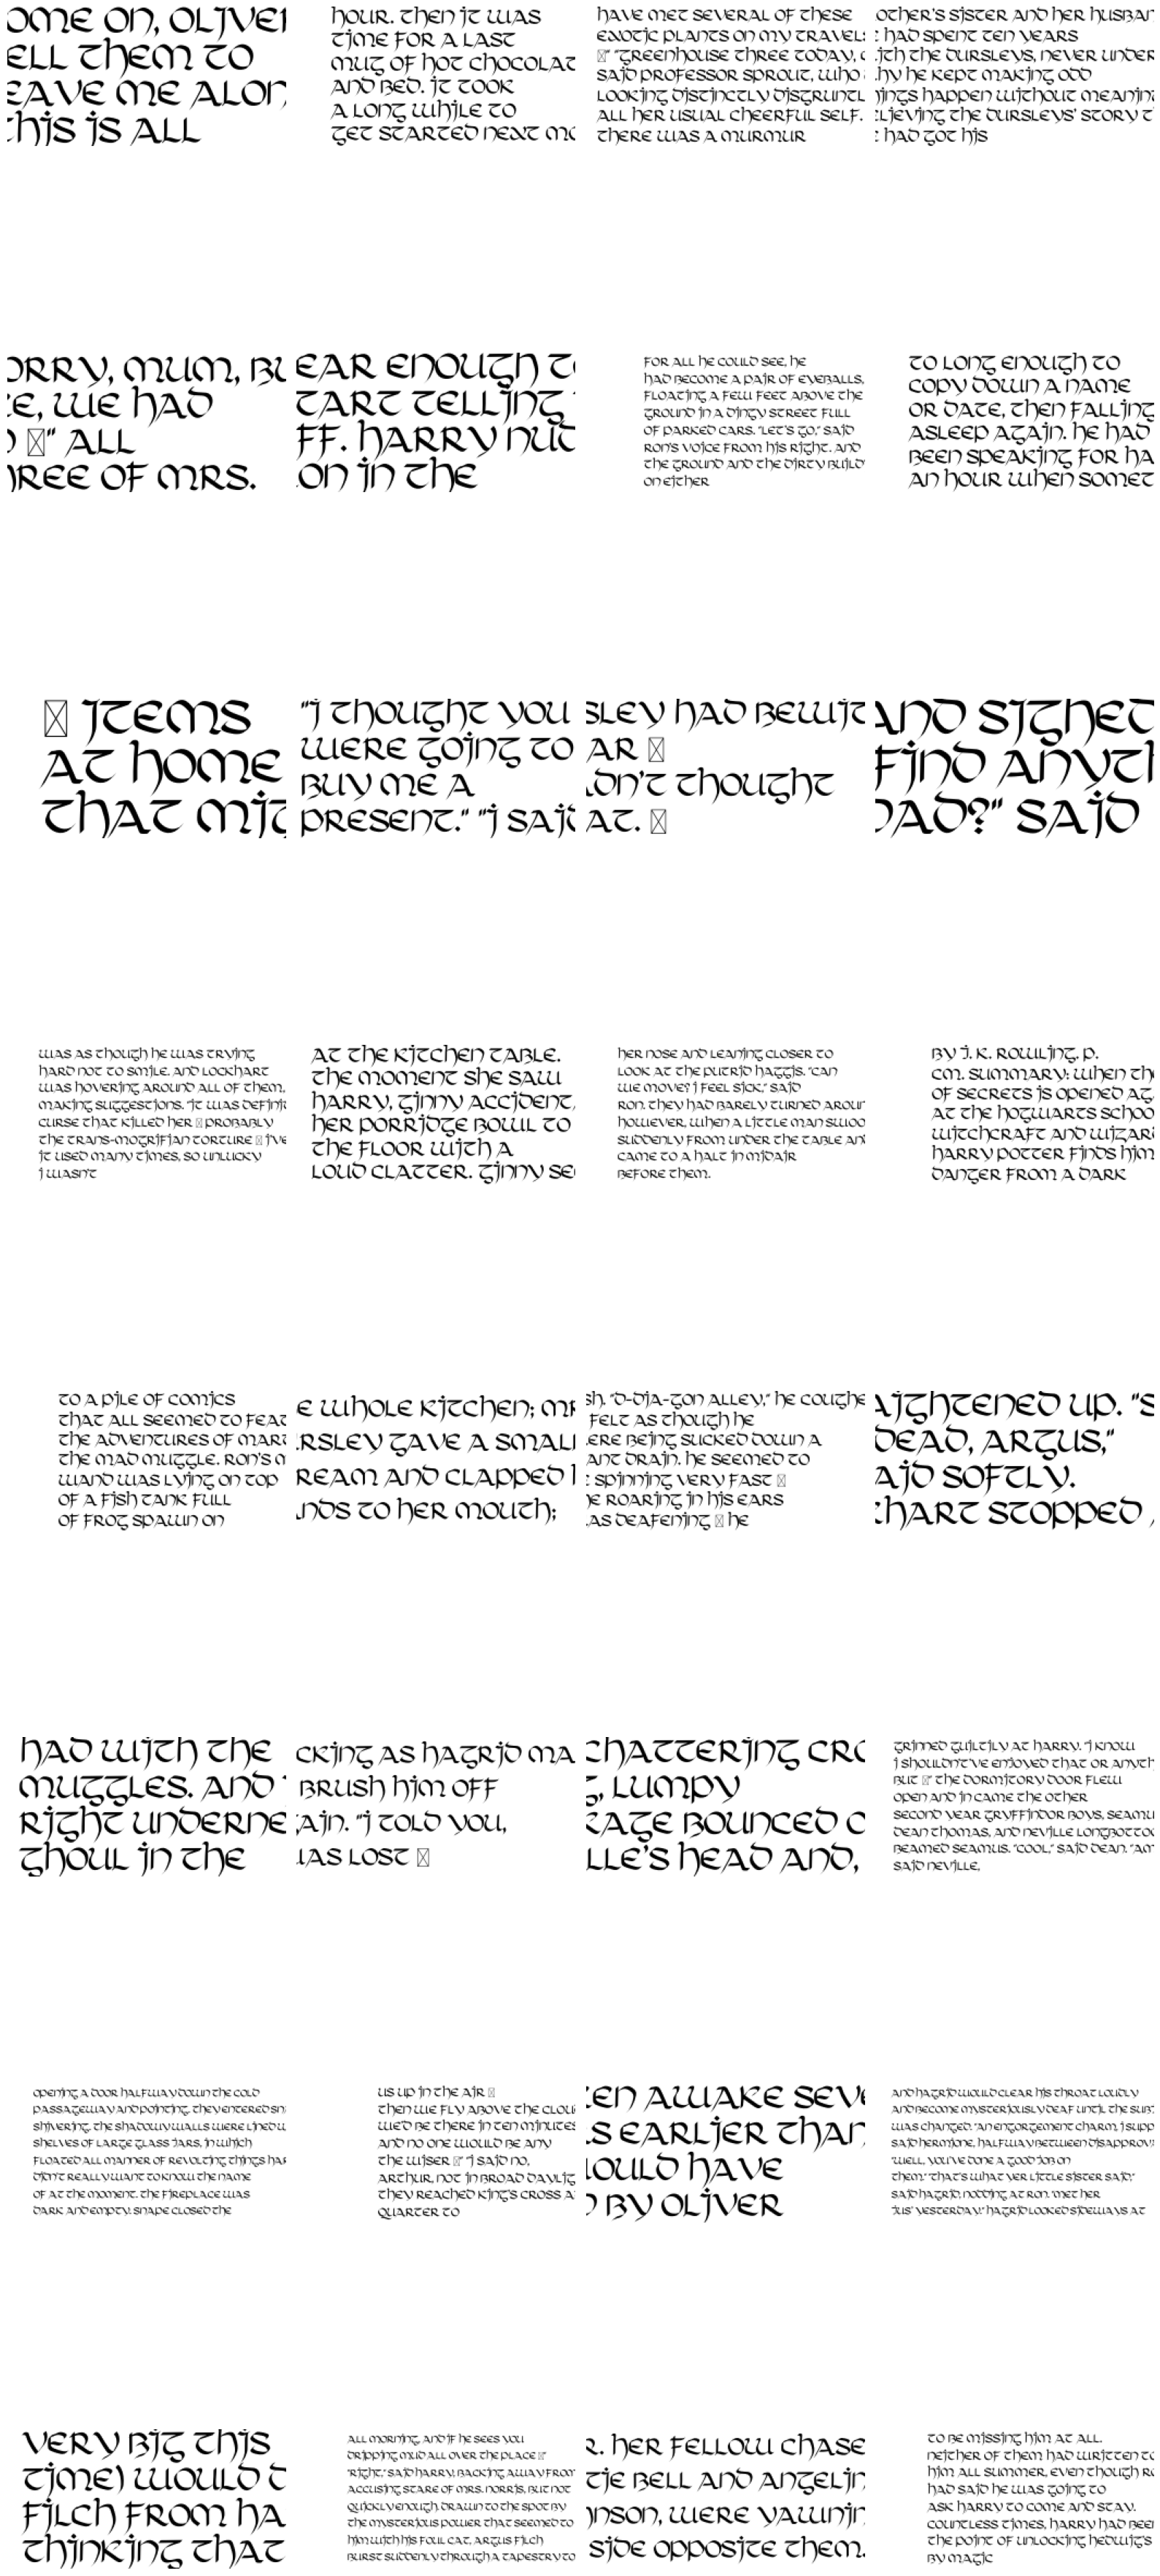

In [31]:
imgs, _ = next(iterator)
print(imgs.shape)
SIZE = imgs.shape[1:]
min_value = np.min(imgs)
max_value = np.max(imgs)
print("Минимальное значение в матрице: ", min_value)
print("Maximal значение в матрице: ", max_value)
num_imgs = 32
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    
    plt.imshow(img, cmap='gray')
    
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [32]:
filepath = 'train_2nd/best_model.keras'


model = keras.saving.load_model(filepath, custom_objects=None, compile=True, safe_mode=True)

In [33]:
# Тестирование модели на тестовом наборе данных
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

2024-04-17 13:37:59.060685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


141/141 ━━━━━━━━━━━━━━━━━━━━ 136s 667ms/step - accuracy: 0.9999 - loss: 8.8404e-04
Loss:  0.0010879791807383299
Accuracy:  0.999833345413208


In [36]:
test_paths = test_df.path.values
test_labels = test_df.class_label.values

test_ds = build_dataset(paths=test_paths,  
                         #labels=test_labels,
                         batch_size=CFG.BATCH_SIZE,
                         repeat=None, 
                         shuffle=None, 
                         augment=None, 
                         cache=False,
                         #cache_dir=CFG.CACHE_DIR
                        )

In [38]:


# Предсказываем метки классов на тестовом наборе данных
y_pred = model.predict(test_ds)

# Получаем истинные метки классов
y_true = test_labels  # замените это на ваши истинные метки

# Вычисляем матрицу ошибок



141/141 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step


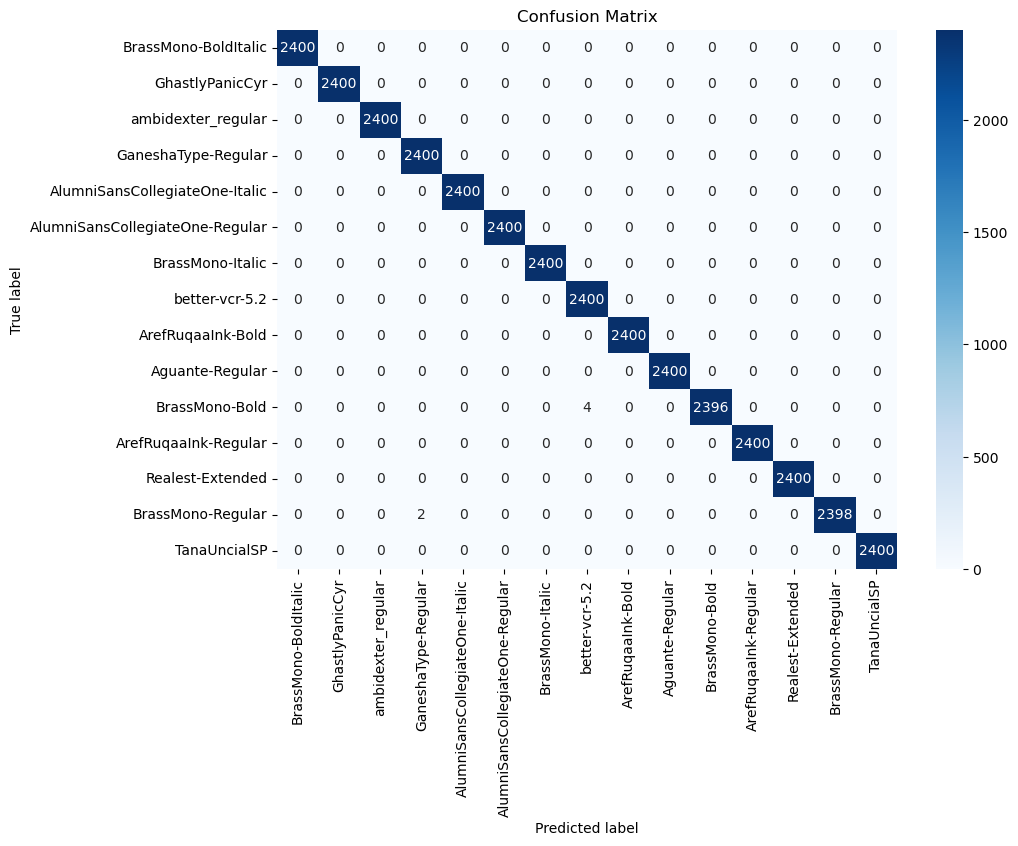

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Вычисляем матрицу ошибок
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Создаем DataFrame для более красивого отображения
cm_df = pd.DataFrame(cm, index=CFG.LABEL2NAME.values(), columns=CFG.LABEL2NAME.values())

plt.figure(figsize=(10,7))

# Используем heatmap из seaborn для визуализации
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#Precosion Recall - macro, micro, average, ROCAUC, PRROC, F1score